In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

child_mind_institute_problematic_internet_use_path = kagglehub.competition_download('child-mind-institute-problematic-internet-use')

print('Data source import complete.')


Data source import complete.


# Análisis y Procesamiento de Datos de Actigrafía

Este notebook tiene como objetivo procesar los datos de actigrafía para preparar un modelo que permita estudiar las relaciones entre la actividad física y el uso problemático de Internet. A continuación se detallan los pasos necesarios para trabajar con estos datos.

## 1. Importación de Bibliotecas

Primero, importamos las bibliotecas necesarias para el análisis y procesamiento de datos.


In [3]:
# Librerías necesarias
!pip install kagglehub
!pip install optuna
!pip install lightgbm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
import optuna  # Para tuning de hiperparámetros
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# Definición de la función personalizada para calcular el QWK
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

In [5]:
# Métrica Kappa Quadrática como scorer
qwk_scorer = make_scorer(quadratic_weighted_kappa, greater_is_better=True)

In [6]:
# Cargar datos de kagglehub
train_data = pd.read_csv(child_mind_institute_problematic_internet_use_path + '/train.csv')
test_data = pd.read_csv(child_mind_institute_problematic_internet_use_path + '/test.csv')

In [7]:

# Seleccionar las mismas 53 features en train que en test
train_features = test_data.columns.tolist()
train_data = train_data[train_features + ['sii']] # Asegúrate de incluir la columna 'sii'

# Eliminar columnas con demasiados nulos (>80%) y otras irrelevantes
threshold = 0.8
missing_frac = train_data.isnull().mean()
columns_to_drop = missing_frac[missing_frac > threshold].index.tolist()
columns_to_drop = [col for col in columns_to_drop if col in train_data.columns] # Filtra las columnas a eliminar

train_data = train_data.drop(columns=columns_to_drop)

# Identificar columnas comunes entre train y test (ahora con el mismo número de columnas)
common_columns = list(set(train_data.columns).intersection(set(test_data.columns)))
num_cols = train_data[common_columns].select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = train_data[common_columns].select_dtypes(include=['object']).columns.tolist()


# Imputación para columnas numéricas y categóricas
for df in [train_data, test_data]:
    num_imputer = SimpleImputer(strategy='median')
    if len(num_cols) > 0:
        df[num_cols] = num_imputer.fit_transform(df[num_cols])
    cat_imputer = SimpleImputer(strategy='most_frequent')
    if len(cat_cols) > 0:
        df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Estandarización
scaler = StandardScaler()
if len(num_cols) > 0:
    train_data[num_cols] = scaler.fit_transform(train_data[num_cols])
    test_data[num_cols] = scaler.transform(test_data[num_cols])

# ... (resto del código sin modificaciones)

In [8]:
# Separar columnas numéricas y categóricas solo de las columnas comunes
num_cols = train_data[common_columns].select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = train_data[common_columns].select_dtypes(include=['object']).columns.tolist()


In [9]:
# Imputación para columnas numéricas
num_imputer = SimpleImputer(strategy='median')
if len(num_cols) > 0:
    train_data[num_cols] = num_imputer.fit_transform(train_data[num_cols])
    test_data[num_cols] = num_imputer.transform(test_data[num_cols])

In [10]:
# Imputación para columnas categóricas
cat_imputer = SimpleImputer(strategy='most_frequent')
if len(cat_cols) > 0:
    train_data[cat_cols] = cat_imputer.fit_transform(train_data[cat_cols])
    test_data[cat_cols] = cat_imputer.transform(test_data[cat_cols])

In [11]:
# Estandarización
scaler = StandardScaler()
if len(num_cols) > 0:
    train_data[num_cols] = scaler.fit_transform(train_data[num_cols])
    test_data[num_cols] = scaler.transform(test_data[num_cols])

In [12]:
# Separación de características y etiqueta
X = train_data.drop(columns=["sii"])
y = train_data["sii"]

In [13]:
# Asegúrate de que y no tenga valores nulos
y = y.dropna()  # Eliminar NaN, si existen
y.reset_index(drop=True, inplace=True)  # Reiniciar índices para problemas potenciales

In [14]:
# Manejo del desbalance
unique_classes = np.unique(y)  # Obtener clases únicas de y

In [15]:
# Comprobar si unique_classes contiene todas las etiquetas esperadas
print("Unique classes in y:", unique_classes)

Unique classes in y: [0. 1. 2. 3.]


In [16]:
# Calcular pesos de clase
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y)

In [17]:
# Crear un diccionario de pesos usando las etiquetas
class_weights_dict = dict(zip(unique_classes, class_weights))

In [18]:
# Verificar los pesos de clase
print("Class weights:", class_weights_dict)

Class weights: {0.0: 0.42910915934755334, 1.0: 0.936986301369863, 2.0: 1.8095238095238095, 3.0: 20.11764705882353}


In [19]:
# Verificar si hay valores nulos en y
if y.isnull().any():
    print("Hay valores nulos en y. Se eliminarán.")
    # Eliminar filas de X donde y es nulo
    valid_indices = y.dropna().index
    X = X.loc[valid_indices]  # Filtrar X para que coincida con y sin nulos
    y = y.dropna()  # Asegúrate de que y también esté limpio

In [20]:
# Ahora ambos deben tener el mismo número de muestras
print(f"Número de muestras en X: {X.shape[0]}, Número de muestras en y: {y.shape[0]}")

Número de muestras en X: 3960, Número de muestras en y: 2736


In [21]:
# Asegurarte de que 'sii' no tenga NaN y que X y y estén alineados
y = train_data["sii"].dropna()  # Asegúrate de que y esté limpio de NaN
X = train_data.loc[y.index].drop(columns=["sii"])  # Filtrar X para que coincida con y limpiado

In [22]:
# Comprobar dimensiones
print(f"Número de muestras en X: {X.shape[0]}, Número de muestras en y: {y.shape[0]}")

Número de muestras en X: 2736, Número de muestras en y: 2736


In [23]:
# División del conjunto de datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
# Verificar los tamaños de los conjuntos de entrenamiento y validación
print("Tamaños de los conjuntos:")
print(f"X_train: {X_train.shape[0]}, X_val: {X_val.shape[0]}")
print(f"y_train: {y_train.shape[0]}, y_val: {y_val.shape[0]}")

Tamaños de los conjuntos:
X_train: 2188, X_val: 548
y_train: 2188, y_val: 548


In [27]:
from sklearn.preprocessing import LabelEncoder

# Get a list of object columns from X_train, excluding 'id'
object_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Check if 'id' is in the list before attempting to remove it
if 'id' in object_cols:
    object_cols.remove('id')  # Remove 'id' from the list of columns to encode

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Apply label encoding to each object column (excluding 'id') in both training and validation sets
for col in object_cols:
    # Fit on the combined unique values from both train and validation sets
    unique_values = pd.concat([X_train[col], X_val[col]]).unique()
    label_encoder.fit(unique_values)

    X_train[col] = label_encoder.transform(X_train[col])
    X_val[col] = label_encoder.transform(X_val[col])


In [31]:
# Get a list of object columns from X_train that are also in test_data
object_cols = X_train.select_dtypes(include=['object']).columns.tolist()
object_cols_test = test_data.select_dtypes(include=['object']).columns.tolist()
common_object_cols = list(set(object_cols).intersection(object_cols_test))

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Apply label encoding to each common object column in both training and validation sets
for col in common_object_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_val[col] = label_encoder.transform(X_val[col])
    # Apply the same encoding to test_data if the column exists
    if col in test_data.columns:
        test_data[col] = label_encoder.transform(test_data[col])

In [34]:

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': len(np.unique(y_train)), # Number of classes in your target variable
        'boosting_type': 'gbdt',  # or 'dart', 'goss'
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'verbose': -1,
        "seed": 42
    }


    # Create and train the LightGBM model
    model = lgb.LGBMClassifier(**params)

    # Remove the 'id' column from X_train and X_val before fitting
    X_train_no_id = X_train.drop(columns=['id'], errors='ignore')  # errors='ignore' to avoid errors if 'id' is already dropped
    X_val_no_id = X_val.drop(columns=['id'], errors='ignore')

    # Use early stopping callback to prevent overfitting and infinite loops
    model.fit(X_train_no_id, y_train,
              eval_set=[(X_val_no_id, y_val)],
              callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=100)]) # Use early_stopping callback

    preds = model.predict(X_val_no_id)  # Predict on validation data without 'id'
    qwk = quadratic_weighted_kappa(y_val, preds)
    return qwk

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximize QWK
study.optimize(objective, n_trials=100) # Adjust n_trials as needed

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-12-06 09:16:50,799] A new study created in memory with name: no-name-3bca9beb-de26-4390-8588-88f785b2e7a5
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:16:51,169] Trial 0 finished with value: 0.34613615608689563 and parameters: {'num_leaves': 93, 'learning_rate': 0.04775528123833636, 'feature_fraction': 0.4464434569444363, 'bagging_fraction': 0.44090258184087755, 'bagging_freq': 1, 'max_depth': 12, 'min_data_in_leaf': 96, 'lambda_l1': 2.846704253780563, 'lambda_l2': 8.621915165771794e-07, 'min_gain_to_split': 0.19100182499770524}. Best is trial 0 with value: 0.34613615608689563.


Did not meet early stopping. Best iteration is:
[74]	valid_0's multi_logloss: 0.860331
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:51,563] Trial 1 finished with value: 0.3809349769079975 and parameters: {'num_leaves': 136, 'learning_rate': 0.2136603622550393, 'feature_fraction': 0.988373159111789, 'bagging_fraction': 0.9141542563978255, 'bagging_freq': 1, 'max_depth': 9, 'min_data_in_leaf': 61, 'lambda_l1': 0.0001552254430356165, 'lambda_l2': 9.971816722399405, 'min_gain_to_split': 5.64218351

Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.854866
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:51,796] Trial 2 finished with value: 0.019244618423210458 and parameters: {'num_leaves': 181, 'learning_rate': 0.09962200045245012, 'feature_fraction': 0.8721642227552477, 'bagging_fraction': 0.45375304724752585, 'bagging_freq': 7, 'max_depth': 4, 'min_data_in_leaf': 82, 'lambda_l1': 0.003856850703139575, 'lambda_l2': 1.2568162213124331e-07, 'min_gain_to_split': 1

Did not meet early stopping. Best iteration is:
[20]	valid_0's multi_logloss: 0.888053
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's multi_logloss: 0.871574

<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:52,005] Trial 3 finished with value: 0.18153671725100295 and parameters: {'num_leaves': 111, 'learning_rate': 0.0887502325858581, 'feature_fraction': 0.4215720359560017, 'bagging_fraction': 0.5543197449004786, 'bagging_freq': 6, 'max_depth': 6, 'min_data_in_leaf': 63, 'lambda_l1': 2.7096297434563856e-08, 'lambda_l2': 3.5094994647126336e-06, 'min_gain_to_split': 12


Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:52,260] Trial 4 finished with value: 0.3334729814650891 and parameters: {'num_leaves': 119, 'learning_rate': 0.08816568400466868, 'feature_fraction': 0.48955564642920324, 'bagging_fraction': 0.6678582432222471, 'bagging_freq': 1, 'max_depth': 8, 'min_data_in_leaf': 63, 'lambda_l1': 3.4843617921161003e-07, 'lambda_l2': 0.0020492268873269085, 'min_gain_to_split': 9.

Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.854366
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:52,583] Trial 5 finished with value: 0.3432179756181776 and parameters: {'num_leaves': 214, 'learning_rate': 0.17546351740721813, 'feature_fraction': 0.5437854417899085, 'bagging_fraction': 0.8474355136812164, 'bagging_freq': 7, 'max_depth': 3, 'min_data_in_leaf': 59, 'lambda_l1': 1.8851168939550037e-06, 'lambda_l2': 0.00012671909650883198, 'min_gain_to_split': 3.

Did not meet early stopping. Best iteration is:
[26]	valid_0's multi_logloss: 0.841285
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:52,836] Trial 6 finished with value: 0.3018825955958182 and parameters: {'num_leaves': 99, 'learning_rate': 0.20112691666463045, 'feature_fraction': 0.8844995874445897, 'bagging_fraction': 0.6987913653314322, 'bagging_freq': 2, 'max_depth': 8, 'min_data_in_leaf': 23, 'lambda_l1': 0.34319289339999276, 'lambda_l2': 1.5493334839629915e-06, 'min_gain_to_split': 10.433

Did not meet early stopping. Best iteration is:
[15]	valid_0's multi_logloss: 0.865077
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.88549


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:53,042] Trial 7 finished with value: 0.26549903068386926 and parameters: {'num_leaves': 124, 'learning_rate': 0.24337512379611842, 'feature_fraction': 0.8120440909325789, 'bagging_fraction': 0.5292540810769155, 'bagging_freq': 5, 'max_depth': 11, 'min_data_in_leaf': 96, 'lambda_l1': 1.4387847629059892e-07, 'lambda_l2': 9.119152474865427e-08, 'min_gain_to_split': 1

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.88133


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:16:53,554] Trial 9 finished with value: 0.2906346345231716 and parameters: {'num_leaves': 249, 'learning_rate': 0.0772463922899155, 'feature_fraction': 0.5199727587400804, 'bagging_fraction': 0.901112185805837, 'bagging_freq': 7, 'max_depth': 3, 'min_data_in_leaf': 64, 'lambda_l1': 0.1909997059058898, 'lambda_l2': 0.004440962662212427, 'min_gain_to_split': 8.431954093639268}. Best is trial 1 with value: 0.3809349769079975.


Did not meet early stopping. Best iteration is:
[38]	valid_0's multi_logloss: 0.862506
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:53,975] Trial 10 finished with value: 0.33994387765067413 and parameters: {'num_leaves': 35, 'learning_rate': 0.29306617883503905, 'feature_fraction': 0.985438649926329, 'bagging_fraction': 0.98607242587865, 'bagging_freq': 4, 'max_depth': 10, 'min_data_in_leaf': 45, 'lambda_l1': 6.723837827778665e-05, 'lambda_l2': 3.4502672796032905, 'min_gain_to_split': 4.147529

Did not meet early stopping. Best iteration is:
[12]	valid_0's multi_logloss: 0.85461
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:54,677] Trial 11 finished with value: 0.3447638765134441 and parameters: {'num_leaves': 35, 'learning_rate': 0.1347706324199972, 'feature_fraction': 0.7082871043461327, 'bagging_fraction': 0.8050338727688837, 'bagging_freq': 1, 'max_depth': 12, 'min_data_in_leaf': 98, 'lambda_l1': 0.0007924041654070681, 'lambda_l2': 0.089143791343303, 'min_gain_to_split': 0.581143

Did not meet early stopping. Best iteration is:
[18]	valid_0's multi_logloss: 0.856038


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:16:55,511] Trial 12 finished with value: 0.0 and parameters: {'num_leaves': 295, 'learning_rate': 0.0038901118043892235, 'feature_fraction': 0.7353772451818497, 'bagging_fraction': 0.42057280536850766, 'bagging_freq': 2, 'max_depth': 10, 'min_data_in_leaf': 83, 'lambda_l1': 5.010199313202088, 'lambda_l2': 9.508806995878422e-05, 'min_gain_to_split': 0.05448662464777776}. Best is trial 1 with value: 0.3809349769079975.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.94038


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:16:56,324] Trial 13 finished with value: 0.07583272256338369 and parameters: {'num_leaves': 71, 'learning_rate': 0.011070868929868416, 'feature_fraction': 0.987963474301, 'bagging_fraction': 0.7741525095817401, 'bagging_freq': 2, 'max_depth': 9, 'min_data_in_leaf': 81, 'lambda_l1': 2.5958880578954993e-05, 'lambda_l2': 1.0550095534179406e-08, 'min_gain_to_split': 5.131652576448031}. Best is trial 1 with value: 0.3809349769079975.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.874308


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:16:57,106] Trial 14 finished with value: 0.3384703273983596 and parameters: {'num_leaves': 166, 'learning_rate': 0.039257719372075825, 'feature_fraction': 0.6535867302539777, 'bagging_fraction': 0.946250675742262, 'bagging_freq': 3, 'max_depth': 12, 'min_data_in_leaf': 22, 'lambda_l1': 0.008954435181617974, 'lambda_l2': 7.531104364523359e-06, 'min_gain_to_split': 6.4133992100836394}. Best is trial 1 with value: 0.3809349769079975.


Did not meet early stopping. Best iteration is:
[80]	valid_0's multi_logloss: 0.852951


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:16:57,813] Trial 15 finished with value: 0.3391906633196209 and parameters: {'num_leaves': 76, 'learning_rate': 0.1379335939422477, 'feature_fraction': 0.7887543347368555, 'bagging_fraction': 0.6357459139052662, 'bagging_freq': 1, 'max_depth': 7, 'min_data_in_leaf': 44, 'lambda_l1': 0.0808641278208213, 'lambda_l2': 7.871165093381033, 'min_gain_to_split': 2.1914924727157117}. Best is trial 1 with value: 0.3809349769079975.


Did not meet early stopping. Best iteration is:
[26]	valid_0's multi_logloss: 0.849343


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:58,155] Trial 16 finished with value: 0.23453052209716474 and parameters: {'num_leaves': 195, 'learning_rate': 0.20727686956720648, 'feature_fraction': 0.43807254838556253, 'bagging_fraction': 0.758250064340329, 'bagging_freq': 3, 'max_depth': 10, 'min_data_in_leaf': 75, 'lambda_l1': 7.45219481314089, 'lambda_l2': 0.030239239956064475, 'min_gain_to_split': 6.88628

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's multi_logloss: 0.876106


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:16:58,560] Trial 17 finished with value: 0.36950157540873807 and parameters: {'num_leaves': 146, 'learning_rate': 0.28843753145048734, 'feature_fraction': 0.6226547337803017, 'bagging_fraction': 0.498072330236163, 'bagging_freq': 4, 'max_depth': 11, 'min_data_in_leaf': 35, 'lambda_l1': 1.3768667488174526e-05, 'lambda_l2': 2.2335485415528965e-05, 'min_gain_to_split': 1.8156497547436825}. Best is trial 1 with value: 0.3809349769079975.


Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.854527
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:58,793] Trial 18 finished with value: 0.34200349301397204 and parameters: {'num_leaves': 142, 'learning_rate': 0.2983469558667791, 'feature_fraction': 0.5819897413327205, 'bagging_fraction': 0.5060832653895992, 'bagging_freq': 5, 'max_depth': 9, 'min_data_in_leaf': 33, 'lambda_l1': 1.5059880438867875e-05, 'lambda_l2': 3.577538120931692e-05, 'min_gain_to_split': 2.

Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.852109
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.850663


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:16:59,188] Trial 20 finished with value: 0.3870358793316908 and parameters: {'num_leaves': 150, 'learning_rate': 0.25748086501566475, 'feature_fraction': 0.6511975323635215, 'bagging_fraction': 0.610961910374682, 'bagging_freq': 5, 'max_depth': 11, 'min_data_in_leaf': 33, 'lambda_l1': 0.0005390564909313685, 'lambda_l2': 0.025051093179129406, 'min_gain_to_split': 2.38

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 0.843581
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:16:59,380] Trial 21 finished with value: 0.4217382046818051 and parameters: {'num_leaves': 144, 'learning_rate': 0.2709039168564914, 'feature_fraction': 0.6486807789586047, 'bagging_fraction': 0.6181595966717942, 'bagging_freq': 5, 'max_depth': 11, 'min_data_in_leaf': 33, 'lambda_l1': 0.00032610181431157165, 'lambda_l2': 0.7173146075461415, 'min_gain_to_split': 2.3636424189473586}. Best is trial 21 with value: 0.4217382046818051.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 0.847195
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's multi_logloss: 0.84683


[I 2024-12-06 09:16:59,579] Trial 22 finished with value: 0.38573856209150326 and parameters: {'num_leaves': 156, 'learning_rate': 0.21441983109091287, 'feature_fraction': 0.7567351521577305, 'bagging_fraction': 0.6244663358202861, 'bagging_freq': 5, 'max_depth': 11, 'min_data_in_leaf': 29, 'lambda_l1': 0.00021845678201519867, 'lambda_l2': 0.6356847607988813, 'min_gain_to_split': 3.399421528983882}. Best is trial 21 with value: 0.4217382046818051.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's multi_logloss: 0.852772
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:00,019] Trial 24 finished with value: 0.3343857930821176 and parameters: {'num_leaves': 197, 'learning_rate': 0.17904128512390227, 'feature_fraction': 0.6774488396962337, 'bagging_fraction': 0.6060755791728792, 'bagging_freq': 6, 'max_depth': 11, 'min_data_in_leaf': 28, 'lambda_l1': 0.01289946424021251, 'lambda_l2': 0.022630956785250827, 'min_gain_to_split': 1.413156343450389}. Best is trial 21 with value: 0.4217382046818051.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.844324
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's multi_logloss: 0.839843


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:00,381] Trial 26 finished with value: 0.3688566725011875 and parameters: {'num_leaves': 169, 'learning_rate': 0.26531702319417594, 'feature_fraction': 0.7928949594798095, 'bagging_fraction': 0.5735393832320501, 'bagging_freq': 5, 'max_depth': 12, 'min_data_in_leaf': 38, 'lambda_l1': 0.020345691773330482, 'lambda_l2': 0.08503912570683737, 'min_gain_to_split': 4.546

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's multi_logloss: 0.854181
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:00,653] Trial 27 finished with value: 0.2752916526552678 and parameters: {'num_leaves': 158, 'learning_rate': 0.17542712651480513, 'feature_fraction': 0.697553928832091, 'bagging_fraction': 0.6899246968252319, 'bagging_freq': 6, 'max_depth': 11, 'min_data_in_leaf': 29, 'lambda_l1': 0.00012209954598339182, 'lambda_l2': 0.0182075917945054, 'min_gain_to_split': 1.2101373043858676}. Best is trial 21 with value: 0.4217382046818051.


Did not meet early stopping. Best iteration is:
[9]	valid_0's multi_logloss: 0.865685
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.865245


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:00,846] Trial 28 finished with value: 0.2586900586426424 and parameters: {'num_leaves': 75, 'learning_rate': 0.22138675450417833, 'feature_fraction': 0.7476197297485049, 'bagging_fraction': 0.6550014799386615, 'bagging_freq': 4, 'max_depth': 9, 'min_data_in_leaf': 21, 'lambda_l1': 0.0010470357800939501, 'lambda_l2': 1.3819907486565646, 'min_gain_to_split': 7.74540

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's multi_logloss: 0.840376
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:01,303] Trial 30 finished with value: 0.3402903402324009 and parameters: {'num_leaves': 190, 'learning_rate': 0.24607931057638466, 'feature_fraction': 0.5764859011185767, 'bagging_fraction': 0.7325336543615567, 'bagging_freq': 6, 'max_depth': 10, 'min_data_in_leaf': 41, 'lambda_l1': 0.003901656337398432, 'lambda_l2': 0.007029413115366578, 'min_gain_to_split': 0.8763287473975745}. Best is trial 21 with value: 0.4217382046818051.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.873248
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's multi_logloss: 0.865277


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:01,667] Trial 32 finished with value: 0.23982501257896793 and parameters: {'num_leaves': 145, 'learning_rate': 0.2002354742931786, 'feature_fraction': 0.6369079028656219, 'bagging_fraction': 0.4898790015740604, 'bagging_freq': 4, 'max_depth': 11, 'min_data_in_leaf': 70, 'lambda_l1': 0.00020293393511827915, 'lambda_l2': 1.800356343391354, 'min_gain_to_split': 6.244

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 0.863577
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:01,870] Trial 33 finished with value: 0.3376924069283468 and parameters: {'num_leaves': 140, 'learning_rate': 0.15630648953652693, 'feature_fraction': 0.847118025019955, 'bagging_fraction': 0.6657750644827338, 'bagging_freq': 5, 'max_depth': 8, 'min_data_in_leaf': 34, 'lambda_l1': 0.0005480441468407597, 'lambda_l2': 3.2324130074378603, 'min_gain_to_split': 4.652919867116504}. Best is trial 21 with value: 0.4217382046818051.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l

Did not meet early stopping. Best iteration is:
[19]	valid_0's multi_logloss: 0.852062
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's multi_logloss: 0.855106


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:02,250] Trial 35 finished with value: 0.3763835837106281 and parameters: {'num_leaves': 108, 'learning_rate': 0.2325624458154637, 'feature_fraction': 0.9265709487334369, 'bagging_fraction': 0.5604224002765268, 'bagging_freq': 5, 'max_depth': 10, 'min_data_in_leaf': 68, 'lambda_l1': 0.001389144950585697, 'lambda_l2': 0.000928573912854849, 'min_gain_to_split': 2.815

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's multi_logloss: 0.830551


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:02,429] Trial 36 finished with value: 0.3831864098974689 and parameters: {'num_leaves': 156, 'learning_rate': 0.18797473029599132, 'feature_fraction': 0.6712797572563209, 'bagging_fraction': 0.45980189401235005, 'bagging_freq': 4, 'max_depth': 9, 'min_data_in_leaf': 57, 'lambda_l1': 9.702727502014822e-06, 'lambda_l2': 0.09729038876714953, 'min_gain_to_split': 4.15

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's multi_logloss: 0.848398
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:02,675] Trial 37 finished with value: 0.35128480333354384 and parameters: {'num_leaves': 155, 'learning_rate': 0.2560404874025736, 'feature_fraction': 0.6587593795729629, 'bagging_fraction': 0.4533349152763062, 'bagging_freq': 3, 'max_depth': 6, 'min_data_in_leaf': 34, 'lambda_l1': 8.65679364275593e-06, 'lambda_l2': 0.06491865847006775, 'min_gain_to_split': 1.7754948073911714}. Best is trial 21 with value: 0.4217382046818051.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

Did not meet early stopping. Best iteration is:
[11]	valid_0's multi_logloss: 0.846923
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[27]	valid_0's multi_logloss: 0.848211


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:03,078] Trial 39 finished with value: 0.4109707317932725 and parameters: {'num_leaves': 182, 'learning_rate': 0.15965962209524617, 'feature_fraction': 0.7720283934811835, 'bagging_fraction': 0.46752773258234603, 'bagging_freq': 4, 'max_depth': 11, 'min_data_in_leaf': 38, 'lambda_l1': 5.427724369823656e-06, 'lambda_l2': 0.17875116014610087, 'min_gain_to_split': 2.4

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's multi_logloss: 0.842727


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:03,252] Trial 40 finished with value: 0.13032814675351845 and parameters: {'num_leaves': 238, 'learning_rate': 0.1165123119274627, 'feature_fraction': 0.7678459188631344, 'bagging_fraction': 0.5474502532242868, 'bagging_freq': 6, 'max_depth': 11, 'min_data_in_leaf': 37, 'lambda_l1': 9.395208525474967e-07, 'lambda_l2': 0.7886146711885174, 'min_gain_to_split': 9.665

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's multi_logloss: 0.871895
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:03,474] Trial 41 finished with value: 0.4126189192953559 and parameters: {'num_leaves': 178, 'learning_rate': 0.1652712181548423, 'feature_fraction': 0.6811745614353428, 'bagging_fraction': 0.4736299889600073, 'bagging_freq': 4, 'max_depth': 11, 'min_data_in_leaf': 30, 'lambda_l1': 9.740532025992763e-06, 'lambda_l2': 0.15979779232131233, 'min_gain_to_split': 2.5344175840641228}. Best is trial 21 with value: 0.4217382046818051.


Did not meet early stopping. Best iteration is:
[25]	valid_0's multi_logloss: 0.844822
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:03,699] Trial 42 finished with value: 0.3842659029427391 and parameters: {'num_leaves': 181, 'learning_rate': 0.16176912685310887, 'feature_fraction': 0.6949656127408244, 'bagging_fraction': 0.47606357550631806, 'bagging_freq': 4, 'max_depth': 12, 'min_data_in_leaf': 25, 'lambda_l1': 9.018503604675083e-08, 'lambda_l2': 0.2047500698735029, 'min_gain_to_split': 2.53

Did not meet early stopping. Best iteration is:
[25]	valid_0's multi_logloss: 0.841161
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:04,087] Trial 43 finished with value: 0.29723517265561095 and parameters: {'num_leaves': 125, 'learning_rate': 0.13759223149145466, 'feature_fraction': 0.607677713948611, 'bagging_fraction': 0.5145447063809854, 'bagging_freq': 5, 'max_depth': 11, 'min_data_in_leaf': 31, 'lambda_l1': 7.325863992468408e-05, 'lambda_l2': 0.0004902818982123918, 'min_gain_to_split': 0.

Did not meet early stopping. Best iteration is:
[16]	valid_0's multi_logloss: 0.870428
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:04,309] Trial 44 finished with value: 0.3168002051150568 and parameters: {'num_leaves': 180, 'learning_rate': 0.11410368039822874, 'feature_fraction': 0.726111053479719, 'bagging_fraction': 0.4289240768554972, 'bagging_freq': 3, 'max_depth': 10, 'min_data_in_leaf': 41, 'lambda_l1': 4.248915360196753e-06, 'lambda_l2': 0.04461230248836638, 'min_gain_to_split': 3.182

Did not meet early stopping. Best iteration is:
[42]	valid_0's multi_logloss: 0.844213
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:05,087] Trial 45 finished with value: 0.24612260825280918 and parameters: {'num_leaves': 210, 'learning_rate': 0.1617381119290937, 'feature_fraction': 0.7822671652793107, 'bagging_fraction': 0.5770973285621612, 'bagging_freq': 5, 'max_depth': 12, 'min_data_in_leaf': 25, 'lambda_l1': 0.003109577700989109, 'lambda_l2': 0.25177856399437665, 'min_gain_to_split': 0.045

Did not meet early stopping. Best iteration is:
[9]	valid_0's multi_logloss: 0.865851
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:05,306] Trial 46 finished with value: 0.3383732712223494 and parameters: {'num_leaves': 112, 'learning_rate': 0.2517963828075058, 'feature_fraction': 0.5465426668009605, 'bagging_fraction': 0.4010632002659872, 'bagging_freq': 4, 'max_depth': 10, 'min_data_in_leaf': 20, 'lambda_l1': 9.006514983688056e-07, 'lambda_l2': 3.7119988134630715, 'min_gain_to_split': 1.7946

Did not meet early stopping. Best iteration is:
[9]	valid_0's multi_logloss: 0.854898
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:05,567] Trial 47 finished with value: 0.4004778331728366 and parameters: {'num_leaves': 169, 'learning_rate': 0.22824457510094312, 'feature_fraction': 0.8510949544470829, 'bagging_fraction': 0.6428813008218927, 'bagging_freq': 7, 'max_depth': 4, 'min_data_in_leaf': 31, 'lambda_l1': 0.0002733421832444803, 'lambda_l2': 0.012605092556778661, 'min_gain_to_split': 1.16

Did not meet early stopping. Best iteration is:
[12]	valid_0's multi_logloss: 0.849434
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's multi_logloss: 0.881233


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:06,157] Trial 49 finished with value: 0.3214313426273182 and parameters: {'num_leaves': 260, 'learning_rate': 0.06396977266902476, 'feature_fraction': 0.8120984661126536, 'bagging_fraction': 0.5242572304466503, 'bagging_freq': 7, 'max_depth': 5, 'min_data_in_leaf': 31, 'lambda_l1': 5.0995885577321804e-05, 'lambda_l2': 0.005069559131535347, 'min_gain_to_split': 0.8915032807526064}. Best is trial 21 with value: 0.4217382046818051.


Did not meet early stopping. Best iteration is:
[45]	valid_0's multi_logloss: 0.84825
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:06,417] Trial 50 finished with value: 0.4083909530684091 and parameters: {'num_leaves': 204, 'learning_rate': 0.28415229102150646, 'feature_fraction': 0.8697984583361343, 'bagging_fraction': 0.6564957569365424, 'bagging_freq': 3, 'max_depth': 3, 'min_data_in_leaf': 43, 'lambda_l1': 0.029580763596052006, 'lambda_l2': 0.00014680477138213387, 'min_gain_to_split': 1.3

Did not meet early stopping. Best iteration is:
[6]	valid_0's multi_logloss: 0.859763
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:06,651] Trial 51 finished with value: 0.358040097027421 and parameters: {'num_leaves': 204, 'learning_rate': 0.2811225718935473, 'feature_fraction': 0.6366022354457952, 'bagging_fraction': 0.6424752137141788, 'bagging_freq': 3, 'max_depth': 3, 'min_data_in_leaf': 36, 'lambda_l1': 0.12203234359349802, 'lambda_l2': 0.00015510523186344834, 'min_gain_to_split': 1.9018

Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.853377
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:06,943] Trial 52 finished with value: 0.3102751129786727 and parameters: {'num_leaves': 176, 'learning_rate': 0.2854705987396182, 'feature_fraction': 0.8747073881229815, 'bagging_fraction': 0.7315359904085792, 'bagging_freq': 3, 'max_depth': 4, 'min_data_in_leaf': 42, 'lambda_l1': 0.03464364313839122, 'lambda_l2': 0.003356702377892407, 'min_gain_to_split': 1.24159

Did not meet early stopping. Best iteration is:
[6]	valid_0's multi_logloss: 0.864278
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:07,265] Trial 53 finished with value: 0.3491467484926787 and parameters: {'num_leaves': 191, 'learning_rate': 0.298932230128654, 'feature_fraction': 0.8998893827994783, 'bagging_fraction': 0.7964883789878144, 'bagging_freq': 2, 'max_depth': 3, 'min_data_in_leaf': 48, 'lambda_l1': 1.67974661642198, 'lambda_l2': 0.0003825853982164641, 'min_gain_to_split': 0.33975931

Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.845784
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:07,487] Trial 54 finished with value: 0.3657248249730245 and parameters: {'num_leaves': 132, 'learning_rate': 0.24358537102668865, 'feature_fraction': 0.8582977804386, 'bagging_fraction': 0.6716181324870992, 'bagging_freq': 4, 'max_depth': 4, 'min_data_in_leaf': 31, 'lambda_l1': 0.005071030774705112, 'lambda_l2': 9.713632032005092e-07, 'min_gain_to_split': 2.46792

Did not meet early stopping. Best iteration is:
[11]	valid_0's multi_logloss: 0.849125
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:07,791] Trial 55 finished with value: 0.37823347904345594 and parameters: {'num_leaves': 264, 'learning_rate': 0.14698306744877562, 'feature_fraction': 0.6907403848095224, 'bagging_fraction': 0.5972796595464566, 'bagging_freq': 2, 'max_depth': 5, 'min_data_in_leaf': 44, 'lambda_l1': 2.4451057319521942e-05, 'lambda_l2': 2.529997488847926e-05, 'min_gain_to_split': 1

Did not meet early stopping. Best iteration is:
[17]	valid_0's multi_logloss: 0.851292
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:08,117] Trial 56 finished with value: 0.36704560149536225 and parameters: {'num_leaves': 173, 'learning_rate': 0.2740136841205225, 'feature_fraction': 0.9503953168225885, 'bagging_fraction': 0.47493960216321435, 'bagging_freq': 3, 'max_depth': 3, 'min_data_in_leaf': 33, 'lambda_l1': 6.314921024317043e-06, 'lambda_l2': 0.017052738432465967, 'min_gain_to_split': 2.2

Did not meet early stopping. Best iteration is:
[19]	valid_0's multi_logloss: 0.854418
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:08,656] Trial 57 finished with value: 0.3264887862711271 and parameters: {'num_leaves': 201, 'learning_rate': 0.11631552136665829, 'feature_fraction': 0.8204255039342766, 'bagging_fraction': 0.7082245653296663, 'bagging_freq': 7, 'max_depth': 6, 'min_data_in_leaf': 91, 'lambda_l1': 0.0004782159700755421, 'lambda_l2': 0.0017073594910812652, 'min_gain_to_split': 0.7

Did not meet early stopping. Best iteration is:
[22]	valid_0's multi_logloss: 0.851914
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:08,946] Trial 58 finished with value: 0.37152437998242316 and parameters: {'num_leaves': 219, 'learning_rate': 0.19971365594483145, 'feature_fraction': 0.6069537596445831, 'bagging_fraction': 0.570575232163472, 'bagging_freq': 3, 'max_depth': 8, 'min_data_in_leaf': 24, 'lambda_l1': 0.03786481579728124, 'lambda_l2': 7.060723535403984e-06, 'min_gain_to_split': 4.756

Did not meet early stopping. Best iteration is:
[43]	valid_0's multi_logloss: 0.842203
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:09,248] Trial 59 finished with value: 0.39808752584424534 and parameters: {'num_leaves': 151, 'learning_rate': 0.2711577784737392, 'feature_fraction': 0.7291555892863671, 'bagging_fraction': 0.6533724496521267, 'bagging_freq': 4, 'max_depth': 5, 'min_data_in_leaf': 38, 'lambda_l1': 2.344995186179162e-05, 'lambda_l2': 0.031233607657876396, 'min_gain_to_split': 3.65

Did not meet early stopping. Best iteration is:
[11]	valid_0's multi_logloss: 0.853912
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:09,597] Trial 60 finished with value: 0.36394075180482943 and parameters: {'num_leaves': 189, 'learning_rate': 0.26727084542868335, 'feature_fraction': 0.7982687444570027, 'bagging_fraction': 0.6447129423820112, 'bagging_freq': 4, 'max_depth': 5, 'min_data_in_leaf': 38, 'lambda_l1': 1.00196342138257e-06, 'lambda_l2': 9.52579984360099e-05, 'min_gain_to_split': 3.87

Did not meet early stopping. Best iteration is:
[19]	valid_0's multi_logloss: 0.858
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:09,893] Trial 61 finished with value: 0.35087391766182763 and parameters: {'num_leaves': 149, 'learning_rate': 0.25785236911312753, 'feature_fraction': 0.660023284677346, 'bagging_fraction': 0.6135036278423442, 'bagging_freq': 4, 'max_depth': 4, 'min_data_in_leaf': 36, 'lambda_l1': 0.4462438630176605, 'lambda_l2': 0.04173178583358863, 'min_gain_to_split': 3.051710

Did not meet early stopping. Best iteration is:
[14]	valid_0's multi_logloss: 0.845474
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:10,259] Trial 62 finished with value: 0.3458456867413602 and parameters: {'num_leaves': 162, 'learning_rate': 0.2340442818433125, 'feature_fraction': 0.7335001438195783, 'bagging_fraction': 0.6743008780406419, 'bagging_freq': 4, 'max_depth': 3, 'min_data_in_leaf': 27, 'lambda_l1': 3.62648671773225e-05, 'lambda_l2': 0.10794141085469558, 'min_gain_to_split': 2.19415

Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 0.850228
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:10,678] Trial 63 finished with value: 0.3675420049792947 and parameters: {'num_leaves': 168, 'learning_rate': 0.2952037138688213, 'feature_fraction': 0.7682299825253807, 'bagging_fraction': 0.7313798142145593, 'bagging_freq': 3, 'max_depth': 5, 'min_data_in_leaf': 43, 'lambda_l1': 1.8150816155895312e-05, 'lambda_l2': 0.4760839652058385, 'min_gain_to_split': 1.1734

Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.863149
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:10,956] Trial 64 finished with value: 0.353390311967386 and parameters: {'num_leaves': 119, 'learning_rate': 0.2862405901469182, 'feature_fraction': 0.7115621343031021, 'bagging_fraction': 0.7585169722065559, 'bagging_freq': 4, 'max_depth': 4, 'min_data_in_leaf': 31, 'lambda_l1': 9.028660260596356e-05, 'lambda_l2': 0.14410250903840469, 'min_gain_to_split': 3.40366

Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.854788
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:11,192] Trial 65 finished with value: 0.39693471903652 and parameters: {'num_leaves': 135, 'learning_rate': 0.2671928102599926, 'feature_fraction': 0.8905637937032417, 'bagging_fraction': 0.6572386751604465, 'bagging_freq': 5, 'max_depth': 7, 'min_data_in_leaf': 50, 'lambda_l1': 0.00032524985054196325, 'lambda_l2': 0.012066812040503987, 'min_gain_to_split': 2.0276

Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.858981
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.88819


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:11,674] Trial 67 finished with value: 0.32246362628042025 and parameters: {'num_leaves': 139, 'learning_rate': 0.1277045562825285, 'feature_fraction': 0.8630772485353184, 'bagging_fraction': 0.7001665292648978, 'bagging_freq': 2, 'max_depth': 6, 'min_data_in_leaf': 52, 'lambda_l1': 0.000233243646170403, 'lambda_l2': 0.00020315047938246626, 'min_gain_to_split': 1.6619166835107602}. Best is trial 21 with value: 0.4217382046818051.


Did not meet early stopping. Best iteration is:
[17]	valid_0's multi_logloss: 0.852899
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:12,075] Trial 68 finished with value: 0.33438779529908924 and parameters: {'num_leaves': 107, 'learning_rate': 0.24757382867961505, 'feature_fraction': 0.966599305541845, 'bagging_fraction': 0.6279665418125103, 'bagging_freq': 6, 'max_depth': 6, 'min_data_in_leaf': 46, 'lambda_l1': 0.0018515285681237985, 'lambda_l2': 1.6701888666201494e-07, 'min_gain_to_split': 0.

Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.854543
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:12,334] Trial 69 finished with value: 0.3804119010288155 and parameters: {'num_leaves': 55, 'learning_rate': 0.10081925298352656, 'feature_fraction': 0.9162785527206696, 'bagging_fraction': 0.7172044462741028, 'bagging_freq': 4, 'max_depth': 4, 'min_data_in_leaf': 54, 'lambda_l1': 3.858278444082481e-06, 'lambda_l2': 0.0010018022015974971, 'min_gain_to_split': 2.65

Did not meet early stopping. Best iteration is:
[30]	valid_0's multi_logloss: 0.84284
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:12,558] Trial 70 finished with value: 0.3634116591696731 and parameters: {'num_leaves': 163, 'learning_rate': 0.17318773015276465, 'feature_fraction': 0.8794422852957122, 'bagging_fraction': 0.8382193196094542, 'bagging_freq': 5, 'max_depth': 7, 'min_data_in_leaf': 40, 'lambda_l1': 0.00015148934252337456, 'lambda_l2': 0.01532445284449328, 'min_gain_to_split': 6.15

Did not meet early stopping. Best iteration is:
[17]	valid_0's multi_logloss: 0.851413
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:12,782] Trial 71 finished with value: 0.3182094466253007 and parameters: {'num_leaves': 153, 'learning_rate': 0.2768382290368472, 'feature_fraction': 0.6850011917537552, 'bagging_fraction': 0.6043719389273956, 'bagging_freq': 5, 'max_depth': 11, 'min_data_in_leaf': 35, 'lambda_l1': 0.000826105555025979, 'lambda_l2': 0.04906902877240447, 'min_gain_to_split': 2.0313

Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.850732
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:13,055] Trial 72 finished with value: 0.3914193507561855 and parameters: {'num_leaves': 125, 'learning_rate': 0.256714301906352, 'feature_fraction': 0.8419577485366262, 'bagging_fraction': 0.6628640184564885, 'bagging_freq': 5, 'max_depth': 3, 'min_data_in_leaf': 39, 'lambda_l1': 0.0003349574833148012, 'lambda_l2': 0.02563554100163144, 'min_gain_to_split': 1.07615

Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.847042
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:13,327] Trial 73 finished with value: 0.35975026371954966 and parameters: {'num_leaves': 128, 'learning_rate': 0.2651402172436054, 'feature_fraction': 0.8542760599598849, 'bagging_fraction': 0.6681094075487393, 'bagging_freq': 6, 'max_depth': 3, 'min_data_in_leaf': 38, 'lambda_l1': 0.00027880654662069287, 'lambda_l2': 5.127886715275557e-05, 'min_gain_to_split': 1.

Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.851815
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's multi_logloss: 0.846763


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:13,522] Trial 74 finished with value: 0.40281188605108054 and parameters: {'num_leaves': 136, 'learning_rate': 0.22354143807551774, 'feature_fraction': 0.8409019837824137, 'bagging_fraction': 0.6883983998882557, 'bagging_freq': 5, 'max_depth': 3, 'min_data_in_leaf': 45, 'lambda_l1': 0.0023235446214852147, 'lambda_l2': 0.028038399076711892, 'min_gain_to_split': 2.9

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's multi_logloss: 0.842569
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:13,917] Trial 76 finished with value: 0.3633730659320856 and parameters: {'num_leaves': 183, 'learning_rate': 0.23937539467352684, 'feature_fraction': 0.9238653526986198, 'bagging_fraction': 0.4375188222072287, 'bagging_freq': 5, 'max_depth': 4, 'min_data_in_leaf': 60, 'lambda_l1': 0.0021351436773004782, 'lambda_l2': 2.014116912845232, 'min_gain_to_split': 4.315741195452166}. Best is trial 21 with value: 0.4217382046818051.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l

Did not meet early stopping. Best iteration is:
[16]	valid_0's multi_logloss: 0.845993
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:14,121] Trial 77 finished with value: 0.3605179359041132 and parameters: {'num_leaves': 144, 'learning_rate': 0.22315266432469288, 'feature_fraction': 0.8884138483632907, 'bagging_fraction': 0.6368668495926849, 'bagging_freq': 6, 'max_depth': 5, 'min_data_in_leaf': 47, 'lambda_l1': 0.008465754609826471, 'lambda_l2': 1.0743227218346891, 'min_gain_to_split': 3.5362324346064553}. Best is trial 21 with value: 0.4217382046818051.


Did not meet early stopping. Best iteration is:
[14]	valid_0's multi_logloss: 0.850657
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:14,331] Trial 78 finished with value: 0.278615025769236 and parameters: {'num_leaves': 161, 'learning_rate': 0.18353123032262902, 'feature_fraction': 0.775480736846534, 'bagging_fraction': 0.7557443973930584, 'bagging_freq': 5, 'max_depth': 4, 'min_data_in_leaf': 42, 'lambda_l1': 1.3393570778565515e-05, 'lambda_l2': 0.07948337526028222, 'min_gain_to_split': 7.7338

Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 0.858082
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's multi_logloss: 0.846462


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:14,752] Trial 80 finished with value: 0.3311997299455347 and parameters: {'num_leaves': 170, 'learning_rate': 0.16988053425804472, 'feature_fraction': 0.40262639027307423, 'bagging_fraction': 0.9871162144420513, 'bagging_freq': 4, 'max_depth': 3, 'min_data_in_leaf': 55, 'lambda_l1': 0.020540837199108257, 'lambda_l2': 0.012136037559851215, 'min_gain_to_split': 1.58

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's multi_logloss: 0.840329


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:14,954] Trial 81 finished with value: 0.422696767077108 and parameters: {'num_leaves': 120, 'learning_rate': 0.2531247006068644, 'feature_fraction': 0.8336887782351493, 'bagging_fraction': 0.6592303410535697, 'bagging_freq': 5, 'max_depth': 3, 'min_data_in_leaf': 40, 'lambda_l1': 0.00047498990968974344, 'lambda_l2': 0.031012277084805022, 'min_gain_to_split': 2.608

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's multi_logloss: 0.846938


<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:15,167] Trial 82 finished with value: 0.3969531877974406 and parameters: {'num_leaves': 116, 'learning_rate': 0.2087020502497335, 'feature_fraction': 0.8268036139075512, 'bagging_fraction': 0.6932550958869601, 'bagging_freq': 5, 'max_depth': 3, 'min_data_in_leaf': 33, 'lambda_l1': 0.0007994363187084074, 'lambda_l2': 0.15991993707997096, 'min_gain_to_split': 2.9055987681894724}. Best is trial 81 with value: 0.422696767077108.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's multi_logloss: 0.843509


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:15,392] Trial 83 finished with value: 0.3657979909994713 and parameters: {'num_leaves': 115, 'learning_rate': 0.2122047307351259, 'feature_fraction': 0.8291531098349926, 'bagging_fraction': 0.7001710167768852, 'bagging_freq': 5, 'max_depth': 3, 'min_data_in_leaf': 29, 'lambda_l1': 0.0007379028380226675, 'lambda_l2': 0.13447515915888972, 'min_gain_to_split': 2.7067

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 0.844484
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:15,624] Trial 84 finished with value: 0.3802891230186404 and parameters: {'num_leaves': 120, 'learning_rate': 0.19400115274721572, 'feature_fraction': 0.8667677412179571, 'bagging_fraction': 0.7187088881427968, 'bagging_freq': 1, 'max_depth': 3, 'min_data_in_leaf': 33, 'lambda_l1': 0.0026121608804336, 'lambda_l2': 0.27285036641218535, 'min_gain_to_split': 3.200330

Did not meet early stopping. Best iteration is:
[18]	valid_0's multi_logloss: 0.837623
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:15,833] Trial 85 finished with value: 0.38651186485449585 and parameters: {'num_leaves': 93, 'learning_rate': 0.23793424757240653, 'feature_fraction': 0.811327752728888, 'bagging_fraction': 0.6878485868778024, 'bagging_freq': 7, 'max_depth': 3, 'min_data_in_leaf': 22, 'lambda_l1': 0.0012036497255720404, 'lambda_l2': 0.03234012751867573, 'min_gain_to_split': 2.4496

Did not meet early stopping. Best iteration is:
[16]	valid_0's multi_logloss: 0.852232
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's multi_logloss: 0.867104


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:16,233] Trial 87 finished with value: 0.3355973744076448 and parameters: {'num_leaves': 87, 'learning_rate': 0.14752893041541415, 'feature_fraction': 0.8463097088463681, 'bagging_fraction': 0.7431431408911574, 'bagging_freq': 5, 'max_depth': 3, 'min_data_in_leaf': 36, 'lambda_l1': 0.00010979213842296314, 'lambda_l2': 0.7623166535260611, 'min_gain_to_split': 3.6975

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's multi_logloss: 0.849682


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:16,423] Trial 88 finished with value: 0.3532694214876033 and parameters: {'num_leaves': 197, 'learning_rate': 0.2229450908240359, 'feature_fraction': 0.792988105741995, 'bagging_fraction': 0.5369072533824717, 'bagging_freq': 5, 'max_depth': 4, 'min_data_in_leaf': 30, 'lambda_l1': 5.5772739558919134e-06, 'lambda_l2': 0.16921285816266082, 'min_gain_to_split': 4.9008

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's multi_logloss: 0.846102
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:16,666] Trial 89 finished with value: 0.3819931694251679 and parameters: {'num_leaves': 186, 'learning_rate': 0.2486213215377571, 'feature_fraction': 0.7617232995161622, 'bagging_fraction': 0.9368637267454969, 'bagging_freq': 4, 'max_depth': 4, 'min_data_in_leaf': 34, 'lambda_l1': 2.7149967809931555e-05, 'lambda_l2': 0.37355271581458044, 'min_gain_to_split': 4.273932967010963}. Best is trial 81 with value: 0.422696767077108.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  '

Did not meet early stopping. Best iteration is:
[14]	valid_0's multi_logloss: 0.844268
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 0.847889


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:17,069] Trial 91 finished with value: 0.4047382713737241 and parameters: {'num_leaves': 134, 'learning_rate': 0.2632905770166858, 'feature_fraction': 0.8293866736725185, 'bagging_fraction': 0.6560673870326007, 'bagging_freq': 5, 'max_depth': 11, 'min_data_in_leaf': 42, 'lambda_l1': 0.00018063605369994065, 'lambda_l2': 0.031884490834142486, 'min_gain_to_split': 1.9

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.857572


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:17,309] Trial 92 finished with value: 0.35548612968320725 and parameters: {'num_leaves': 176, 'learning_rate': 0.2802420836227965, 'feature_fraction': 0.8389633760297597, 'bagging_fraction': 0.6453865664729633, 'bagging_freq': 5, 'max_depth': 11, 'min_data_in_leaf': 32, 'lambda_l1': 0.00016051472104579168, 'lambda_l2': 0.04529536251016596, 'min_gain_to_split': 1.5

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's multi_logloss: 0.862184


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:17,544] Trial 93 finished with value: 0.3545941370236102 and parameters: {'num_leaves': 131, 'learning_rate': 0.26093061798714706, 'feature_fraction': 0.827164767133355, 'bagging_fraction': 0.6904868015637662, 'bagging_freq': 4, 'max_depth': 10, 'min_data_in_leaf': 37, 'lambda_l1': 6.057826295755046e-05, 'lambda_l2': 0.025605978844112143, 'min_gain_to_split': 2.03

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's multi_logloss: 0.864265


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:17,767] Trial 94 finished with value: 0.36606221787586246 and parameters: {'num_leaves': 104, 'learning_rate': 0.1671838503564555, 'feature_fraction': 0.784130540669858, 'bagging_fraction': 0.4803639814653323, 'bagging_freq': 5, 'max_depth': 12, 'min_data_in_leaf': 41, 'lambda_l1': 0.000497919209630076, 'lambda_l2': 0.008009580853036321, 'min_gain_to_split': 2.396

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's multi_logloss: 0.845392


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:17,965] Trial 95 finished with value: 0.38470444540573556 and parameters: {'num_leaves': 205, 'learning_rate': 0.29231144561156536, 'feature_fraction': 0.6704510109017214, 'bagging_fraction': 0.6561195048150709, 'bagging_freq': 5, 'max_depth': 11, 'min_data_in_leaf': 45, 'lambda_l1': 1.6597768614837098e-06, 'lambda_l2': 0.10102963985446485, 'min_gain_to_split': 3.

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's multi_logloss: 0.854322
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:18,228] Trial 96 finished with value: 0.29012373252333956 and parameters: {'num_leaves': 144, 'learning_rate': 0.22686593527523344, 'feature_fraction': 0.7020607344747238, 'bagging_fraction': 0.6777698924536744, 'bagging_freq': 4, 'max_depth': 11, 'min_data_in_leaf': 35, 'lambda_l1': 8.836308285329656e-06, 'lambda_l2': 0.26885501837968767, 'min_gain_to_split': 1.4620846796053055}. Best is trial 81 with value: 0.422696767077108.


Did not meet early stopping. Best iteration is:
[8]	valid_0's multi_logloss: 0.867231
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:18,529] Trial 97 finished with value: 0.3244884523921485 and parameters: {'num_leaves': 156, 'learning_rate': 0.019727895712622207, 'feature_fraction': 0.7259023900038125, 'bagging_fraction': 0.6166369375934091, 'bagging_freq': 5, 'max_depth': 12, 'min_data_in_leaf': 28, 'lambda_l1': 0.0011173893848651693, 'lambda_l2': 0.06306126829583521, 'min_gain_to_split': 3.8

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.848173
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:18,905] Trial 98 finished with value: 0.2899079792936967 and parameters: {'num_leaves': 121, 'learning_rate': 0.24469593634575654, 'feature_fraction': 0.8731459235534471, 'bagging_fraction': 0.6354494133675985, 'bagging_freq': 4, 'max_depth': 10, 'min_data_in_leaf': 43, 'lambda_l1': 8.430379333073736e-05, 'lambda_l2': 0.19671110216915988, 'min_gain_to_split': 0.68

Did not meet early stopping. Best iteration is:
[5]	valid_0's multi_logloss: 0.864271
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:19,124] Trial 99 finished with value: 0.3279643336148228 and parameters: {'num_leaves': 111, 'learning_rate': 0.20576153827584215, 'feature_fraction': 0.8079439830533398, 'bagging_fraction': 0.7791088160415174, 'bagging_freq': 3, 'max_depth': 3, 'min_data_in_leaf': 37, 'lambda_l1': 0.004825411604451251, 'lambda_l2': 0.01904696184148921, 'min_gain_to_split': 2.7668

Did not meet early stopping. Best iteration is:
[20]	valid_0's multi_logloss: 0.848118
Number of finished trials:  100
Best trial:
  Value:  0.422696767077108
  Params: 
    num_leaves: 120
    learning_rate: 0.2531247006068644
    feature_fraction: 0.8336887782351493
    bagging_fraction: 0.6592303410535697
    bagging_freq: 5
    max_depth: 3
    min_data_in_leaf: 40
    lambda_l1: 0.00047498990968974344
    lambda_l2: 0.031012277084805022
    min_gain_to_split: 2.6082670201662994


In [35]:
# Iniciar la optimización con Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-12-06 09:17:51,585] A new study created in memory with name: no-name-b6868638-7019-438a-b665-167a0c349a0d
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:51,716] Trial 0 finished with value: 0.32964670126299733 and parameters: {'num_leaves': 244, 'learning_rate': 0.23577116475239202, 'feature_fraction': 0.8856596990008889, 'bagging_fraction': 0.5059656447486958, 'bagging_freq': 7, 'max_depth': 9, 'min_d

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's multi_logloss: 0.866911
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:51,900] Trial 1 finished with value: 0.13656713174251311 and parameters: {'num_leaves': 152, 'learning_rate': 0.09261917667968607, 'feature_fraction': 0.876636106351097, 'bagging_fraction': 0.9946665231576955, 'bagging_freq': 3, 'max_depth': 7, 'min_data_in_leaf': 26, 'lambda_l1': 1.2527475890226022e-07, 'lambda_l2': 2.62226570715011e-06, 'min_gain_to_split': 11.638656544612076}. Best is trial 0 with value: 0.32964670126299733.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Did not meet early stopping. Best iteration is:
[37]	valid_0's multi_logloss: 0.870877
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:52,109] Trial 2 finished with value: 0.3566713496660957 and parameters: {'num_leaves': 231, 'learning_rate': 0.21908375241424105, 'feature_fraction': 0.5658099240054382, 'bagging_fraction': 0.6087160286293575, 'bagging_freq': 1, 'max_depth': 7, 'min_data_in_leaf': 63, 'lambda_l1': 2.1205985944906677e-07, 'lambda_l2': 1.4208267480511495e-07, 'min_gain_to_split': 1.8243612526681119}. Best is trial 2 with value: 0.3566713496660957.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

Did not meet early stopping. Best iteration is:
[14]	valid_0's multi_logloss: 0.842806
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's multi_logloss: 0.878575
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:52,371] Trial 4 finished with value: 0.07356678296076147 and parameters: {'num_leaves': 152, 'learning_rate': 0.18355745859091346, 'feature_fraction': 0.6082783548661541, 'bagging_fraction': 0.5192517175010434, 'bagging_freq': 2, 'max_depth': 9, 'min_data_in_leaf': 61, 'lambda_l1': 3.2402259491137615, 'lambda_l2': 7.643027877249252e-05, 'min_gain_to_split': 13.052

Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 0.893653
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's multi_logloss: 0.858354


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.912936


[I 2024-12-06 09:17:52,783] Trial 6 finished with value: 0.0 and parameters: {'num_leaves': 54, 'learning_rate': 0.005190725181261642, 'feature_fraction': 0.4984468705246915, 'bagging_fraction': 0.7928037466951685, 'bagging_freq': 3, 'max_depth': 5, 'min_data_in_leaf': 37, 'lambda_l1': 1.2093091335783899e-06, 'lambda_l2': 3.823697226104931e-08, 'min_gain_to_split': 5.547038996689991}. Best is trial 2 with value: 0.3566713496660957.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': t

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 0.854254
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:53,073] Trial 8 finished with value: 0.05093485309451384 and parameters: {'num_leaves': 293, 'learning_rate': 0.055646392980300524, 'feature_fraction': 0.8862435347074912, 'bagging_fraction': 0.5783924649262295, 'bagging_freq': 3, 'max_depth': 11, 'min_data_in_leaf': 36, 'lambda_l1': 4.868868125333494e-05, 'lambda_l2': 1.352043733681178e-06, 'min_gain_to_split': 13.121786027000502}. Best is trial 7 with value: 0.35928497658376257.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

Did not meet early stopping. Best iteration is:
[31]	valid_0's multi_logloss: 0.887765
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.862282


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:53,563] Trial 10 finished with value: 0.3450104311543811 and parameters: {'num_leaves': 103, 'learning_rate': 0.2741164388374142, 'feature_fraction': 0.783892468594837, 'bagging_fraction': 0.7833783375114829, 'bagging_freq': 5, 'max_depth': 12, 'min_data_in_leaf': 100, 'lambda_l1': 1.0047173475145171e-08, 'lambda_l2': 0.040289921063501266, 'min_gain_to_split': 0.6592557685202349}. Best is trial 7 with value: 0.35928497658376257.


Did not meet early stopping. Best iteration is:
[9]	valid_0's multi_logloss: 0.857431
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:53,768] Trial 11 finished with value: 0.32548838437170013 and parameters: {'num_leaves': 22, 'learning_rate': 0.17935842477973335, 'feature_fraction': 0.400954419866011, 'bagging_fraction': 0.4174801935783573, 'bagging_freq': 1, 'max_depth': 7, 'min_data_in_leaf': 74, 'lambda_l1': 1.9206146465392498e-07, 'lambda_l2': 2.119696701970437e-08, 'min_gain_to_split': 2.0

Did not meet early stopping. Best iteration is:
[14]	valid_0's multi_logloss: 0.854404
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:53,983] Trial 12 finished with value: 0.3758105261818252 and parameters: {'num_leaves': 112, 'learning_rate': 0.28863045152492306, 'feature_fraction': 0.638277637244345, 'bagging_fraction': 0.6848261996717472, 'bagging_freq': 1, 'max_depth': 10, 'min_data_in_leaf': 56, 'lambda_l1': 1.2097921593529148e-08, 'lambda_l2': 1.1104883025094032e-05, 'min_gain_to_split': 3.699017217481912}. Best is trial 12 with value: 0.3758105261818252.


Did not meet early stopping. Best iteration is:
[15]	valid_0's multi_logloss: 0.846349
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's multi_logloss: 0.841557


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:54,184] Trial 13 finished with value: 0.29754104227533296 and parameters: {'num_leaves': 105, 'learning_rate': 0.29005763624180214, 'feature_fraction': 0.7607181669357284, 'bagging_fraction': 0.7452148576462428, 'bagging_freq': 1, 'max_depth': 11, 'min_data_in_leaf': 51, 'lambda_l1': 1.8044054341551342e-08, 'lambda_l2': 1.8990943747619085e-05, 'min_gain_to_split':

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's multi_logloss: 0.837919
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:54,588] Trial 15 finished with value: 0.3487892376681615 and parameters: {'num_leaves': 128, 'learning_rate': 0.29745197083436214, 'feature_fraction': 0.6245630276336623, 'bagging_fraction': 0.8487032088767913, 'bagging_freq': 2, 'max_depth': 10, 'min_data_in_leaf': 95, 'lambda_l1': 0.011899282399089108, 'lambda_l2': 1.9832031525653482, 'min_gain_to_split': 3.5281982153186364}. Best is trial 14 with value: 0.402812523690395.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  '

Did not meet early stopping. Best iteration is:
[15]	valid_0's multi_logloss: 0.848477
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's multi_logloss: 0.867485


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:54,978] Trial 17 finished with value: 0.3615575303719718 and parameters: {'num_leaves': 31, 'learning_rate': 0.1355156314806026, 'feature_fraction': 0.49194007632290937, 'bagging_fraction': 0.8860046837415245, 'bagging_freq': 1, 'max_depth': 12, 'min_data_in_leaf': 89, 'lambda_l1': 0.7117364133738622, 'lambda_l2': 6.740098919832127e-06, 'min_gain_to_split': 3.3320

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.835182


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:55,346] Trial 18 finished with value: 0.3062068875503319 and parameters: {'num_leaves': 120, 'learning_rate': 0.25280297828346865, 'feature_fraction': 0.6840496900789472, 'bagging_fraction': 0.7143081684639345, 'bagging_freq': 4, 'max_depth': 10, 'min_data_in_leaf': 71, 'lambda_l1': 0.0064588426770349145, 'lambda_l2': 0.3130074749434941, 'min_gain_to_split': 0.4777846447938696}. Best is trial 14 with value: 0.402812523690395.


Did not meet early stopping. Best iteration is:
[9]	valid_0's multi_logloss: 0.863906
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's multi_logloss: 0.858763


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:55,539] Trial 19 finished with value: 0.26310476901591495 and parameters: {'num_leaves': 174, 'learning_rate': 0.17023178750348378, 'feature_fraction': 0.539491982828988, 'bagging_fraction': 0.8597985599968141, 'bagging_freq': 2, 'max_depth': 11, 'min_data_in_leaf': 63, 'lambda_l1': 1.8265996308117284e-05, 'lambda_l2': 0.00010874258067521966, 'min_gain_to_split': 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[27]	valid_0's multi_logloss: 0.85056


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:56,120] Trial 21 finished with value: 0.2941488827336788 and parameters: {'num_leaves': 26, 'learning_rate': 0.12796785016791343, 'feature_fraction': 0.4545386599626459, 'bagging_fraction': 0.859550893928929, 'bagging_freq': 1, 'max_depth': 12, 'min_data_in_leaf': 90, 'lambda_l1': 8.955610679161893, 'lambda_l2': 8.694031968346336e-06, 'min_gain_to_split': 3.120657

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's multi_logloss: 0.86303


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[72]	valid_0's multi_logloss: 0.843944


[I 2024-12-06 09:17:56,451] Trial 22 finished with value: 0.3638868051423989 and parameters: {'num_leaves': 50, 'learning_rate': 0.09603815602433487, 'feature_fraction': 0.6036758900435528, 'bagging_fraction': 0.9172127195711266, 'bagging_freq': 1, 'max_depth': 12, 'min_data_in_leaf': 85, 'lambda_l1': 0.4229891536890776, 'lambda_l2': 2.1154280209103243e-05, 'min_gain_to_split': 3.386757854231562}. Best is trial 14 with value: 0.402812523690395.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  '

Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:17:56,823] Trial 23 finished with value: 0.336373987271375 and parameters: {'num_leaves': 55, 'learning_rate': 0.08736372536525083, 'feature_fraction': 0.6171991003305466, 'bagging_fraction': 0.9912826074944712, 'bagging_freq': 1, 'max_depth': 11, 'min_data_in_leaf': 79, 'lambda_l1': 0.1348386161610248, 'lambda_l2': 0.0012766140311835715, 'min_gain_to_split': 2.2253560833549653}. Best is trial 14 with value: 0.402812523690395.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.846461
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:57,192] Trial 24 finished with value: 0.3492938499605299 and parameters: {'num_leaves': 129, 'learning_rate': 0.055339263093550625, 'feature_fraction': 0.7223997362672319, 'bagging_fraction': 0.9352273992510718, 'bagging_freq': 2, 'max_depth': 11, 'min_data_in_leaf': 55, 'lambda_l1': 0.08763471524795682, 'lambda_l2': 4.7094143722767784e-05, 'min_gain_to_split': 4.

Did not meet early stopping. Best iteration is:
[71]	valid_0's multi_logloss: 0.844039
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:57,497] Trial 25 finished with value: 0.3709744173413694 and parameters: {'num_leaves': 57, 'learning_rate': 0.274626222716759, 'feature_fraction': 0.6378802255167324, 'bagging_fraction': 0.7878175286507088, 'bagging_freq': 1, 'max_depth': 12, 'min_data_in_leaf': 69, 'lambda_l1': 0.001722666807850236, 'lambda_l2': 0.00030660041274916603, 'min_gain_to_split': 6.129

Did not meet early stopping. Best iteration is:
[88]	valid_0's multi_logloss: 0.842793
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:57,790] Trial 26 finished with value: 0.3306565353236114 and parameters: {'num_leaves': 99, 'learning_rate': 0.26806832656262003, 'feature_fraction': 0.6498943194931539, 'bagging_fraction': 0.7971862041450163, 'bagging_freq': 5, 'max_depth': 10, 'min_data_in_leaf': 68, 'lambda_l1': 0.0022363054857685995, 'lambda_l2': 0.000448755708717616, 'min_gain_to_split': 6.28

Did not meet early stopping. Best iteration is:
[12]	valid_0's multi_logloss: 0.852365
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:58,073] Trial 27 finished with value: 0.3453851862460453 and parameters: {'num_leaves': 136, 'learning_rate': 0.2994855439736424, 'feature_fraction': 0.565370367743061, 'bagging_fraction': 0.6937346242679793, 'bagging_freq': 2, 'max_depth': 8, 'min_data_in_leaf': 46, 'lambda_l1': 0.00013305571607118217, 'lambda_l2': 0.03013498018331186, 'min_gain_to_split': 14.680

Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 0.863341
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:58,374] Trial 28 finished with value: 0.3661127403062888 and parameters: {'num_leaves': 80, 'learning_rate': 0.24014941220823613, 'feature_fraction': 0.7446317650904166, 'bagging_fraction': 0.7448652794342285, 'bagging_freq': 3, 'max_depth': 6, 'min_data_in_leaf': 76, 'lambda_l1': 0.001458471486119726, 'lambda_l2': 0.006932490425572602, 'min_gain_to_split': 5.4299

Did not meet early stopping. Best iteration is:
[14]	valid_0's multi_logloss: 0.845243
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:58,688] Trial 29 finished with value: 0.31756156071403385 and parameters: {'num_leaves': 200, 'learning_rate': 0.20614917696968282, 'feature_fraction': 0.6658140945205031, 'bagging_fraction': 0.8295506409293212, 'bagging_freq': 7, 'max_depth': 9, 'min_data_in_leaf': 66, 'lambda_l1': 8.741821469342144e-06, 'lambda_l2': 0.25207198046060497, 'min_gain_to_split': 7.73

Did not meet early stopping. Best iteration is:
[12]	valid_0's multi_logloss: 0.862013
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:58,889] Trial 30 finished with value: 0.4042863409976517 and parameters: {'num_leaves': 106, 'learning_rate': 0.2739360226156376, 'feature_fraction': 0.5530268930522129, 'bagging_fraction': 0.6519890474897937, 'bagging_freq': 1, 'max_depth': 11, 'min_data_in_leaf': 57, 'lambda_l1': 5.2063757897063445e-08, 'lambda_l2': 0.00032231097600039245, 'min_gain_to_split': 7

Did not meet early stopping. Best iteration is:
[90]	valid_0's multi_logloss: 0.832255
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.836514


[I 2024-12-06 09:17:59,088] Trial 31 finished with value: 0.362818884402232 and parameters: {'num_leaves': 113, 'learning_rate': 0.27679570428910494, 'feature_fraction': 0.5664751668370452, 'bagging_fraction': 0.6559960719016698, 'bagging_freq': 1, 'max_depth': 11, 'min_data_in_leaf': 57, 'lambda_l1': 4.125937966539792e-08, 'lambda_l2': 0.0003143494810689464, 'min_gain_to_split': 6.703165566901095}. Best is trial 30 with value: 0.4042863409976517.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.855151
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:59,461] Trial 33 finished with value: 0.3460403148601213 and parameters: {'num_leaves': 151, 'learning_rate': 0.24232752540997685, 'feature_fraction': 0.5092547667451338, 'bagging_fraction': 0.5680910906307927, 'bagging_freq': 2, 'max_depth': 10, 'min_data_in_leaf': 46, 'lambda_l1': 6.777594940336439e-08, 'lambda_l2': 0.008781179667131574, 'min_gain_to_split': 10.68331403156444}. Best is trial 30 with value: 0.4042863409976517.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Did not meet early stopping. Best iteration is:
[21]	valid_0's multi_logloss: 0.862339
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's multi_logloss: 0.855289


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:17:59,828] Trial 35 finished with value: 0.29271973613226165 and parameters: {'num_leaves': 140, 'learning_rate': 0.22767521971096227, 'feature_fraction': 0.5821616334681724, 'bagging_fraction': 0.5444197251948787, 'bagging_freq': 2, 'max_depth': 9, 'min_data_in_leaf': 29, 'lambda_l1': 2.9736376576537998e-08, 'lambda_l2': 8.41436955472814, 'min_gain_to_split': 8.6170

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's multi_logloss: 0.873269
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:18:00,089] Trial 36 finished with value: 0.3227265178902189 and parameters: {'num_leaves': 218, 'learning_rate': 0.25654462156075863, 'feature_fraction': 0.5327778310312606, 'bagging_fraction': 0.6327245692202305, 'bagging_freq': 1, 'max_depth': 8, 'min_data_in_leaf': 48, 'lambda_l1': 4.313099607675129e-07, 'lambda_l2': 0.006165281918672741, 'min_gain_to_split': 1.284275314618477}. Best is trial 30 with value: 0.4042863409976517.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

Did not meet early stopping. Best iteration is:
[14]	valid_0's multi_logloss: 0.856185
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's multi_logloss: 0.872417


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:18:00,454] Trial 38 finished with value: 0.3440243849765837 and parameters: {'num_leaves': 99, 'learning_rate': 0.28183898782540107, 'feature_fraction': 0.46466805258254, 'bagging_fraction': 0.7276959881334066, 'bagging_freq': 1, 'max_depth': 10, 'min_data_in_leaf': 20, 'lambda_l1': 2.635758079608825e-06, 'lambda_l2': 0.034430073443869315, 'min_gain_to_split': 11.872

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's multi_logloss: 0.855157
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:18:00,632] Trial 39 finished with value: 0.2503132919323846 and parameters: {'num_leaves': 90, 'learning_rate': 0.24275009714277718, 'feature_fraction': 0.5366340338428206, 'bagging_fraction': 0.588174383959621, 'bagging_freq': 3, 'max_depth': 3, 'min_data_in_leaf': 58, 'lambda_l1': 5.070403229436466e-07, 'lambda_l2': 0.001154921634561249, 'min_gain_to_split': 7.783046737841446}. Best is trial 30 with value: 0.4042863409976517.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  '

Did not meet early stopping. Best iteration is:
[10]	valid_0's multi_logloss: 0.856599
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's multi_logloss: 0.8524


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:18:01,014] Trial 41 finished with value: 0.37120701068625284 and parameters: {'num_leaves': 114, 'learning_rate': 0.26508037036986604, 'feature_fraction': 0.6445015046059037, 'bagging_fraction': 0.6647788563877383, 'bagging_freq': 1, 'max_depth': 12, 'min_data_in_leaf': 62, 'lambda_l1': 0.00016054590278368437, 'lambda_l2': 0.00019522380481262186, 'min_gain_to_split':

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's multi_logloss: 0.846612


[I 2024-12-06 09:18:01,219] Trial 42 finished with value: 0.3995654407804734 and parameters: {'num_leaves': 117, 'learning_rate': 0.2870849404620629, 'feature_fraction': 0.7057611620151552, 'bagging_fraction': 0.6489335751803774, 'bagging_freq': 1, 'max_depth': 12, 'min_data_in_leaf': 42, 'lambda_l1': 0.0001346951282697991, 'lambda_l2': 3.479914071888814e-06, 'min_gain_to_split': 5.093382587305177}. Best is trial 30 with value: 0.4042863409976517.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's multi_logloss: 0.847717


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:18:01,426] Trial 43 finished with value: 0.34565342473381067 and parameters: {'num_leaves': 144, 'learning_rate': 0.2918245844358575, 'feature_fraction': 0.6923522621625404, 'bagging_fraction': 0.6235823049413216, 'bagging_freq': 1, 'max_depth': 12, 'min_data_in_leaf': 49, 'lambda_l1': 1.2658681263501766e-07, 'lambda_l2': 5.540656846382448e-06, 'min_gain_to_split': 4

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's multi_logloss: 0.848591
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:18:01,669] Trial 44 finished with value: 0.36841774696010443 and parameters: {'num_leaves': 163, 'learning_rate': 0.2280546737370518, 'feature_fraction': 0.8246045272932264, 'bagging_fraction': 0.649352176584952, 'bagging_freq': 1, 'max_depth': 11, 'min_data_in_leaf': 42, 'lambda_l1': 1.1272575099885867e-05, 'lambda_l2': 2.44863352465578e-07, 'min_gain_to_split': 2.6267896968188027}. Best is trial 30 with value: 0.4042863409976517.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

Did not meet early stopping. Best iteration is:
[14]	valid_0's multi_logloss: 0.845614
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[15]	valid_0's multi_logloss: 0.847848


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:18:02,050] Trial 46 finished with value: 0.3785858534378962 and parameters: {'num_leaves': 122, 'learning_rate': 0.25076221800408405, 'feature_fraction': 0.7066953873539463, 'bagging_fraction': 0.6872117471642529, 'bagging_freq': 5, 'max_depth': 11, 'min_data_in_leaf': 33, 'lambda_l1': 3.3567273969682436e-05, 'lambda_l2': 1.4813431516443736e-06, 'min_gain_to_split': 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's multi_logloss: 0.850092
Training until validation scores don't improve for 100 rounds


[I 2024-12-06 09:18:02,238] Trial 47 finished with value: 0.3728643086485024 and parameters: {'num_leaves': 115, 'learning_rate': 0.2591230845647486, 'feature_fraction': 0.7877675168462906, 'bagging_fraction': 0.6948363006827579, 'bagging_freq': 5, 'max_depth': 10, 'min_data_in_leaf': 32, 'lambda_l1': 6.870015513287554e-05, 'lambda_l2': 8.250181137793302e-08, 'min_gain_to_split': 4.035265179391457}. Best is trial 30 with value: 0.4042863409976517.
<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),


Did not meet early stopping. Best iteration is:
[13]	valid_0's multi_logloss: 0.853197
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:18:02,502] Trial 48 finished with value: 0.3290401369794028 and parameters: {'num_leaves': 126, 'learning_rate': 0.2806017914017618, 'feature_fraction': 0.7176291323191023, 'bagging_fraction': 0.75627844561798, 'bagging_freq': 6, 'max_depth': 11, 'min_data_in_leaf': 27, 'lambda_l1': 2.7381268188623667e-05, 'lambda_l2': 1.696788476936301e-06, 'min_gain_to_split': 1.149776483509473}. Best is trial 30 with value: 0.4042863409976517.


Did not meet early stopping. Best iteration is:
[6]	valid_0's multi_logloss: 0.875273
Training until validation scores don't improve for 100 rounds


<ipython-input-34-3b55cde02c14>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-34-3b55cde02c14>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
[I 2024-12-06 09:18:02,722] Trial 49 finished with value: 0.33093988188380186 and parameters: {'num_leaves': 92, 'learning_rate': 0.21418375293166106, 'feature_fraction': 0.6686689735326801, 'bagging_fraction': 0.6798932890451088, 'bagging_freq': 5, 'max_depth': 6, 'min_data_in_leaf': 34, 'lambda_l1': 0.00022914729200023532, 'lambda_l2': 5.828305174144383e-07, 'min_gain_to_split': 2.

Did not meet early stopping. Best iteration is:
[19]	valid_0's multi_logloss: 0.841331


In [36]:
# Resultado de los mejores parámetros
print("Mejores parámetros:", study.best_params)
print("Mejor QWK:", study.best_value)

Mejores parámetros: {'num_leaves': 106, 'learning_rate': 0.2739360226156376, 'feature_fraction': 0.5530268930522129, 'bagging_fraction': 0.6519890474897937, 'bagging_freq': 1, 'max_depth': 11, 'min_data_in_leaf': 57, 'lambda_l1': 5.2063757897063445e-08, 'lambda_l2': 0.00032231097600039245, 'min_gain_to_split': 7.142103959318646}
Mejor QWK: 0.4042863409976517


In [40]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Feature selection (assuming 'best_features' is a list of feature names)
best_features = list(X_train.columns) # Replace with your actual list of best features

# Remove 'id' from best_features if it's present
if 'id' in best_features:
    best_features.remove('id')

X_train_selected = X_train[best_features]
X_val_selected = X_val[best_features]
test_data_selected = test_data[list(set(best_features).intersection(test_data.columns))]

# ----> Apply Label Encoding to object columns in test_data_selected <----
for col in test_data_selected.select_dtypes(include=['object']).columns:
    # Create a LabelEncoder object for each column
    label_encoder = LabelEncoder()

    # Fit on the combined unique values from train and test
    all_values = pd.concat([X_train[col], test_data_selected[col]]).unique()

    # Convert all values to strings before fitting
    all_values = all_values.astype(str)  # This line is the key change

    label_encoder.fit(all_values)

    # Transform the column in test_data_selected
    test_data_selected[col] = label_encoder.transform(test_data_selected[col])

# Redefine the objective function with selected features

def objective(trial):
    params = {
        # ... (your parameters)
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_selected, y_train,
              eval_set=[(X_val_selected, y_val)],
              callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=100)])

    preds = model.predict(X_val_selected)
    qwk = quadratic_weighted_kappa(y_val, preds)
    return qwk



# Retrain the model with the best parameters and selected features
best_params = study.best_params  # Access the best parameters

model = lgb.LGBMClassifier(**best_params)
model.fit(X_train_selected, y_train, eval_set=[(X_val_selected, y_val)],
          callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=100)])

# Predict on the test data
test_preds = model.predict(test_data_selected)


# Prepare the submission
submission_df = pd.DataFrame({'id': test_data['id'], 'SII': test_preds})
submission_df.to_csv('submission.csv', index=False)

<ipython-input-40-50c620b2e108>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_selected[col] = label_encoder.transform(test_data_selected[col])
<ipython-input-40-50c620b2e108>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_selected[col] = label_encoder.transform(test_data_selected[col])
<ipython-input-40-50c620b2e108>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's multi_logloss: 0.844907


In [43]:
# prompt: Hacemos preds para probar el modelo

import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score

# Assuming 'model' is your trained LGBMClassifier and 'test_data_selected' is your preprocessed test data
# Make predictions on the test set, using the selected features
preds = model.predict(test_data_selected)  # Use test_data_selected here



# Create a submission dataframe
submission_df = pd.DataFrame({'id': test_data['id'], 'sii': preds})

# Save the predictions to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Predictions saved to submission.csv")

Predictions saved to submission.csv


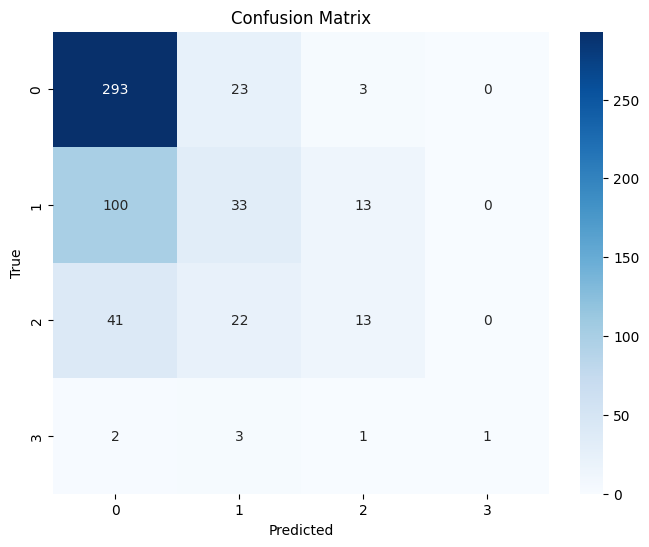

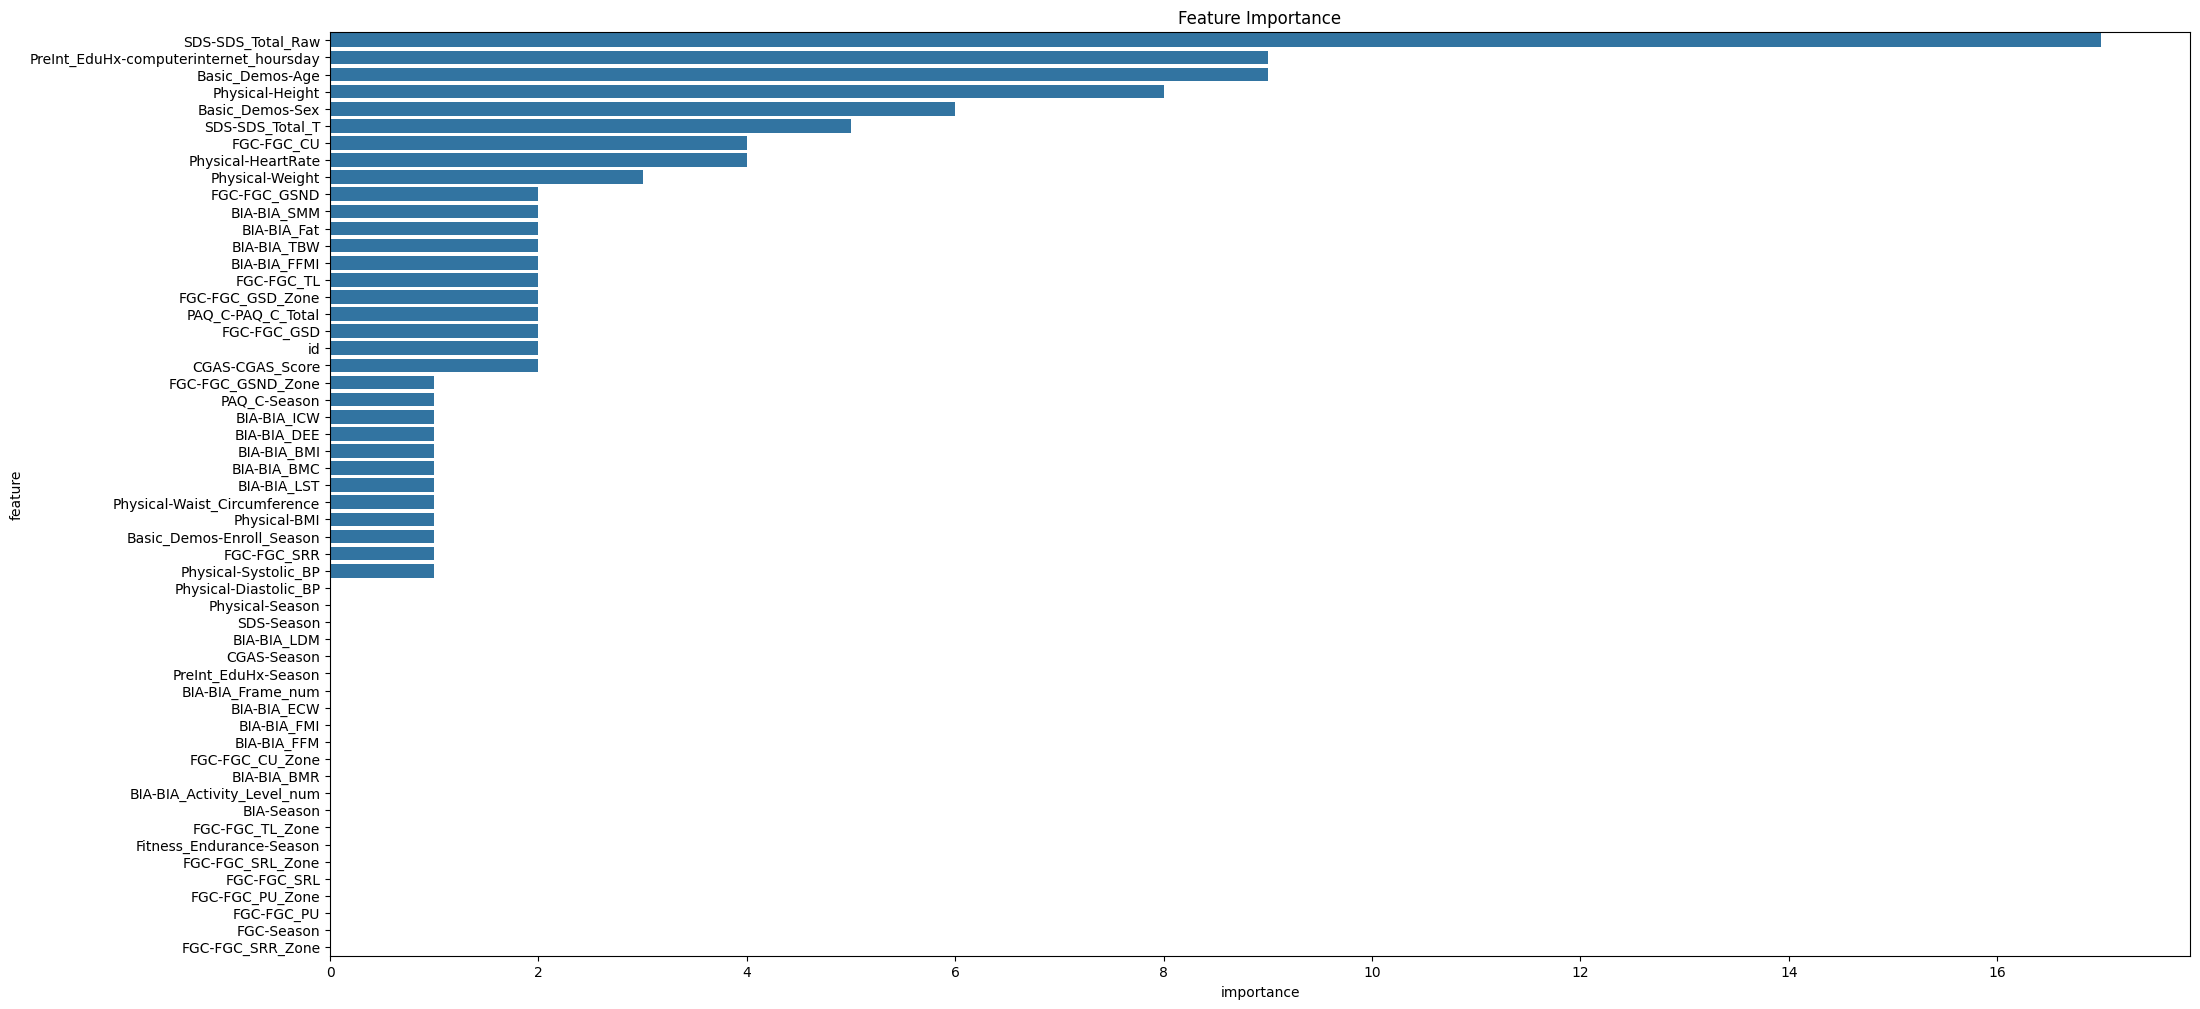

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix

# Predict on the validation set
val_preds = model.predict(X_val_selected) # predict on validation set

cm = confusion_matrix(y_val, val_preds)  # Use validation predictions (val_preds) here

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot feature importance
lgbm_model = lgb.LGBMClassifier(**study.best_params)  # Assuming study is your Optuna study
lgbm_model.fit(X_train, y_train)

# Get feature importance
feature_importance = lgbm_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(24, 12))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()